In [1]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from data_treatment import CreditCardDataSet
from discriminator import *
from generator import *
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import glob

In [2]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): 
        return n.cuda() 
    return n

In [3]:
files_dropdown = widgets.Dropdown(
    options=glob.glob("*.csv"),
    description='File:',
    value = 'diabetes.csv',
    disabled=False,
)
display(files_dropdown)

Dropdown(description='File:', index=2, options=('creditcard.csv', 'data.csv', 'diabetes.csv'), value='diabetes…

In [4]:
file_name=files_dropdown.value
if file_name == "data.csv":
    message = "Breast Cancer Wisconsin (Diagnostic) Data Set"
    class_name = "diagnosis"
    values_names = {0: "Benign", 1: "Malignant"}
    class_len = 32
elif file_name == "creditcard.csv":
    message = "Credit Card Fraud Detection"
    class_name = "Class"
    values_names = {0: "No Frauds", 1: "Frauds"}
    class_len = 31
elif file_name == "diabetes.csv":
    message="Pima Indians Diabetes Database"
    class_name = "Outcome"
    values_names = {0: "Normal", 1: "Diabets"}
    class_len = 9
else:
     exit()

In [26]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    print(real_data)
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    print(fake_data)
    print("!!!!!!!!!!!!")
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [27]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [28]:
lr = 0.0002
#lr= 0.0002
d_steps = 1
batch_size = 5
num_epochs = 1000
print_interval = 100
num_test_samples = 16
loss = nn.BCELoss()

In [29]:
discriminator = DiscriminatorNet(class_len)
generator = GeneratorNet(class_len)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [30]:
d_error_plt = [0]
g_error_plt = [0]

generated_points = []

In [31]:

test_noise = noise(num_test_samples)
database = CreditCardDataSet (csv_file=file_name, root_dir=".")

data_loader = torch.utils.data.DataLoader(database, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

In [32]:
for epoch in range(num_epochs):
    print("Epoch ", epoch)

    for n_batch, real_batch in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(real_batch).float()
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        generated_points.append(fake_data)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress

        #if (n_batch) % print_interval == 0:
    filename = "results/" + file_name[:-4] + "/" + str(epoch) + "_" + str(n_batch) + ".txt"
    print(filename)
    file = open(filename, "w")
    print("Discriminator error: ", d_error)
    print("Generator error: ", g_error)
    print("")

    file.write("Discriminator error: " + str(d_error) + "\n")
    file.write("Generator error: " + str(g_error) + "\n")
    file.write("Points: " + str(fake_data) + "\n\n\n")

    d_error_plt.append(d_error)
    g_error_plt.append(g_error)
        #     #display.clear_output(True)
        #     # Display Images
        #     test_images = generator(test_noise).data.cpu()
        #     logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        #     # Display status Logs
        #     #logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)
        # # Model Checkpoints


Epoch  0
tensor([[9.0312e+04, 1.0000e+00, 1.9550e+01, 2.3210e+01, 1.2890e+02, 1.1740e+03,
         1.0100e-01, 1.3180e-01, 1.8560e-01, 1.0210e-01, 1.9890e-01, 5.8840e-02,
         6.1070e-01, 2.8360e+00, 5.3830e+00, 7.0100e+01, 1.1240e-02, 4.0970e-02,
         7.4690e-02, 3.4410e-02, 2.7680e-02, 6.2400e-03, 2.0820e+01, 3.0440e+01,
         1.4200e+02, 1.3130e+03, 1.2510e-01, 2.4140e-01, 3.8290e-01, 1.8250e-01,
         2.5760e-01, 7.6020e-02],
        [8.6160e+05, 0.0000e+00, 1.2360e+01, 2.1800e+01, 7.9780e+01, 4.6610e+02,
         8.7720e-02, 9.4450e-02, 6.0150e-02, 3.7450e-02, 1.9300e-01, 6.4040e-02,
         2.9780e-01, 1.5020e+00, 2.2030e+00, 2.0950e+01, 7.1120e-03, 2.4930e-02,
         2.7030e-02, 1.2930e-02, 1.9580e-02, 4.4630e-03, 1.3830e+01, 3.0500e+01,
         9.1460e+01, 5.7470e+02, 1.3040e-01, 2.4630e-01, 2.4340e-01, 1.2050e-01,
         2.9720e-01, 9.2610e-02],
        [8.6887e+05, 0.0000e+00, 1.1280e+01, 1.3390e+01, 7.3000e+01, 3.8480e+02,
         1.1640e-01, 1.1360e-01,

tensor([[9.0298e+05, 0.0000e+00, 1.2210e+01, 1.4090e+01, 7.8780e+01, 4.6200e+02,
         8.1080e-02, 7.8230e-02, 6.8390e-02, 2.5340e-02, 1.6460e-01, 6.1540e-02,
         2.6660e-01, 8.3090e-01, 2.0970e+00, 1.9960e+01, 4.4050e-03, 3.0260e-02,
         4.3440e-02, 1.0870e-02, 1.9210e-02, 4.6220e-03, 1.3130e+01, 1.9290e+01,
         8.7650e+01, 5.2990e+02, 1.0260e-01, 2.4310e-01, 3.0760e-01, 9.1400e-02,
         2.6770e-01, 8.8240e-02],
        [8.6468e+05, 0.0000e+00, 1.1930e+01, 2.1530e+01, 7.6530e+01, 4.3860e+02,
         9.7680e-02, 7.8490e-02, 3.3280e-02, 2.0080e-02, 1.6880e-01, 6.1940e-02,
         3.1180e-01, 9.2270e-01, 2.0000e+00, 2.4790e+01, 7.8030e-03, 2.5070e-02,
         1.8350e-02, 7.7110e-03, 1.2780e-02, 3.8560e-03, 1.3670e+01, 2.6150e+01,
         8.7540e+01, 5.8300e+02, 1.5000e-01, 2.3990e-01, 1.5030e-01, 7.2470e-02,
         2.4380e-01, 8.5410e-02],
        [8.9383e+07, 0.0000e+00, 1.4610e+01, 1.5690e+01, 9.2680e+01, 6.6490e+02,
         7.6180e-02, 3.5150e-02, 1.4470e-

tensor([[8.6118e+06, 1.0000e+00, 1.9100e+01, 2.6290e+01, 1.2910e+02, 1.1320e+03,
         1.2150e-01, 1.7910e-01, 1.9370e-01, 1.4690e-01, 1.6340e-01, 7.2240e-02,
         5.1900e-01, 2.9100e+00, 5.8010e+00, 6.7100e+01, 7.5450e-03, 6.0500e-02,
         2.1340e-02, 1.8430e-02, 3.0560e-02, 1.0390e-02, 2.0330e+01, 3.2720e+01,
         1.4130e+02, 1.2980e+03, 1.3920e-01, 2.8170e-01, 2.4320e-01, 1.8410e-01,
         2.3110e-01, 9.2030e-02],
        [9.1165e+05, 0.0000e+00, 1.4200e+01, 2.0530e+01, 9.2410e+01, 6.1840e+02,
         8.9310e-02, 1.1080e-01, 5.0630e-02, 3.0580e-02, 1.5060e-01, 6.0090e-02,
         3.4780e-01, 1.0180e+00, 2.7490e+00, 3.1010e+01, 4.1070e-03, 3.2880e-02,
         2.8210e-02, 1.3500e-02, 1.6100e-02, 2.7440e-03, 1.6450e+01, 2.7260e+01,
         1.1210e+02, 8.2850e+02, 1.1530e-01, 3.4290e-01, 2.5120e-01, 1.3390e-01,
         2.5340e-01, 7.8580e-02],
        [9.1124e+06, 0.0000e+00, 1.3210e+01, 2.5250e+01, 8.4100e+01, 5.3790e+02,
         8.7910e-02, 5.2050e-02, 2.7720e-

tensor([[ 0.0167,  0.0423,  0.0609,  0.1172,  0.1281,  0.2458,  0.1483,  0.1957,
         -0.2257,  0.0418,  0.1651, -0.1557, -0.1799,  0.0807, -0.0604, -0.0077,
         -0.1658, -0.1432,  0.3952,  0.2258, -0.1389, -0.0073, -0.0926,  0.1300,
          0.1611,  0.2342,  0.0557,  0.0067,  0.2039,  0.0349, -0.1392,  0.2679],
        [ 0.0109,  0.1198,  0.0447,  0.1152,  0.0684,  0.2011,  0.2061,  0.1617,
         -0.2183,  0.0406,  0.1176, -0.1696, -0.0620, -0.0087, -0.0256, -0.0963,
         -0.1407, -0.1224,  0.3438,  0.1869, -0.1475, -0.0080, -0.0292,  0.0853,
          0.1383,  0.2153,  0.0534,  0.0543,  0.0655,  0.0761, -0.0594,  0.2426],
        [ 0.0817,  0.0578,  0.0389,  0.0994,  0.0630,  0.1822,  0.1548,  0.2121,
         -0.2166, -0.0040,  0.1106, -0.1562, -0.1031,  0.0979, -0.0821, -0.0373,
         -0.0863, -0.1066,  0.3455,  0.1595, -0.1465, -0.0142, -0.0392,  0.1120,
          0.0987,  0.2367,  0.0563, -0.0249,  0.1137,  0.0109, -0.1266,  0.2321],
        [ 0.0221,  0.0627

tensor([[-0.0509,  0.1873, -0.0579,  0.2451, -0.0007,  0.1956,  0.0941,  0.1473,
         -0.2117, -0.1743,  0.0508, -0.2055, -0.1885,  0.2959, -0.2582,  0.1755,
          0.0218,  0.0760,  0.3085,  0.2161,  0.0245,  0.0020, -0.2030,  0.0415,
         -0.1102,  0.3063, -0.1469, -0.1970,  0.1314, -0.0486, -0.2404,  0.0492],
        [-0.0987,  0.1905, -0.0290,  0.2113,  0.0323,  0.2293,  0.0828,  0.0818,
         -0.1418, -0.1279,  0.0329, -0.0922, -0.1532,  0.3260, -0.2736,  0.1396,
          0.0040,  0.0599,  0.2431,  0.1768,  0.0252, -0.0337, -0.1815,  0.0290,
         -0.1782,  0.3308, -0.1713, -0.1913,  0.1219, -0.0891, -0.2429,  0.0717],
        [-0.1369,  0.1923, -0.1252,  0.2407,  0.0306,  0.1194,  0.0575,  0.0561,
         -0.2136, -0.1555,  0.0974, -0.0683, -0.1995,  0.3376, -0.3053,  0.1974,
         -0.0098,  0.0799,  0.3129,  0.2171, -0.0064, -0.0339, -0.1810,  0.0729,
         -0.1823,  0.3213, -0.1869, -0.2376,  0.1638, -0.0875, -0.2354,  0.0760],
        [-0.0881,  0.1752

tensor([[-0.1542,  0.0084, -0.0977,  0.2052, -0.0891,  0.0042, -0.0294, -0.1568,
         -0.0397, -0.3736, -0.0980,  0.0442,  0.0316,  0.4110, -0.5004,  0.4065,
          0.2846,  0.3482, -0.0170,  0.0375,  0.1351,  0.1027, -0.0908,  0.0862,
         -0.2879,  0.1469, -0.2581, -0.3105, -0.1144, -0.1312, -0.0448, -0.2338],
        [-0.2716,  0.1062, -0.1797,  0.4312, -0.0791,  0.0558, -0.0693, -0.2121,
         -0.0800, -0.5054, -0.1218,  0.1085,  0.0234,  0.6616, -0.7503,  0.5495,
          0.3613,  0.4649, -0.0215,  0.0051,  0.3198,  0.1326, -0.1659,  0.0926,
         -0.5067,  0.2003, -0.4279, -0.4704, -0.0109, -0.2714, -0.1978, -0.2472],
        [-0.1869,  0.0259, -0.1128,  0.2354, -0.0417,  0.0068,  0.0094, -0.0985,
         -0.0096, -0.3470, -0.0665,  0.0147, -0.0281,  0.3635, -0.4682,  0.3914,
          0.2187,  0.2938, -0.0388,  0.0060,  0.1706,  0.0886, -0.0887,  0.1046,
         -0.3044,  0.0986, -0.2108, -0.2799, -0.0401, -0.1498, -0.0826, -0.1870],
        [-0.2667,  0.0269

tensor([[9.1138e+06, 0.0000e+00, 9.6670e+00, 1.8490e+01, 6.1490e+01, 2.8910e+02,
         8.9460e-02, 6.2580e-02, 2.9480e-02, 1.5140e-02, 2.2380e-01, 6.4130e-02,
         3.7760e-01, 1.3500e+00, 2.5690e+00, 2.2730e+01, 7.5010e-03, 1.9890e-02,
         2.7140e-02, 9.8830e-03, 1.9600e-02, 3.9130e-03, 1.1140e+01, 2.5620e+01,
         7.0880e+01, 3.8520e+02, 1.2340e-01, 1.5420e-01, 1.2770e-01, 6.5600e-02,
         3.1740e-01, 8.5240e-02],
        [9.1519e+05, 0.0000e+00, 9.2680e+00, 1.2870e+01, 6.1490e+01, 2.4870e+02,
         1.6340e-01, 2.2390e-01, 9.7300e-02, 5.2520e-02, 2.3780e-01, 9.5020e-02,
         4.0760e-01, 1.0930e+00, 3.0140e+00, 2.0040e+01, 9.7830e-03, 4.5420e-02,
         3.4830e-02, 2.1880e-02, 2.5420e-02, 1.0450e-02, 1.0280e+01, 1.6380e+01,
         6.9050e+01, 3.0020e+02, 1.9020e-01, 3.4410e-01, 2.0990e-01, 1.0250e-01,
         3.0380e-01, 1.2520e-01],
        [8.8995e+07, 1.0000e+00, 2.0730e+01, 3.1120e+01, 1.3570e+02, 1.4190e+03,
         9.4690e-02, 1.1430e-01, 1.3670e-

tensor([[8.6121e+06, 0.0000e+00, 1.2000e+01, 1.5650e+01, 7.6950e+01, 4.4330e+02,
         9.7230e-02, 7.1650e-02, 4.1510e-02, 1.8630e-02, 2.0790e-01, 5.9680e-02,
         2.2710e-01, 1.2550e+00, 1.4410e+00, 1.6160e+01, 5.9690e-03, 1.8120e-02,
         2.0070e-02, 7.0270e-03, 1.9720e-02, 2.6070e-03, 1.3670e+01, 2.4900e+01,
         8.7780e+01, 5.6790e+02, 1.3770e-01, 2.0030e-01, 2.2670e-01, 7.6320e-02,
         3.3790e-01, 7.9240e-02],
        [8.7980e+05, 0.0000e+00, 9.8760e+00, 1.7270e+01, 6.2920e+01, 2.9540e+02,
         1.0890e-01, 7.2320e-02, 1.7560e-02, 1.9520e-02, 1.9340e-01, 6.2850e-02,
         2.1370e-01, 1.3420e+00, 1.5170e+00, 1.2330e+01, 9.7190e-03, 1.2490e-02,
         7.9750e-03, 7.5270e-03, 2.2100e-02, 2.4720e-03, 1.0420e+01, 2.3220e+01,
         6.7080e+01, 3.3160e+02, 1.4150e-01, 1.2470e-01, 6.2130e-02, 5.5880e-02,
         2.9890e-01, 7.3800e-02],
        [8.6731e+07, 1.0000e+00, 1.6160e+01, 2.1540e+01, 1.0620e+02, 8.0980e+02,
         1.0080e-01, 1.2840e-01, 1.0430e-

tensor([[ 0.8343, -0.8359,  0.8112, -1.0868, -0.6962, -1.4642,  0.2344, -1.8915,
          0.3153,  0.2275,  0.8549,  1.5003, -0.1437, -0.2776,  0.4987,  0.1503,
          0.8458,  0.5029, -1.4746, -1.8523, -0.0999, -0.8008,  1.2843, -1.2143,
         -0.6978, -1.4872,  0.8128,  0.7919, -0.5676,  0.9917,  1.0505, -0.4466],
        [ 0.9973, -1.0444,  1.0300, -1.2551, -0.8093, -1.7494,  0.3003, -2.3253,
          0.3293,  0.2772,  0.9644,  1.7787, -0.2050, -0.3310,  0.6271,  0.1623,
          0.9589,  0.7188, -1.8342, -2.2376, -0.0961, -1.0415,  1.6582, -1.3724,
         -0.7381, -1.7740,  0.9813,  0.9933, -0.7453,  1.1555,  1.3011, -0.5250],
        [ 0.7962, -0.8487,  0.8052, -1.0340, -0.7024, -1.4651,  0.2176, -1.8909,
          0.2760,  0.1928,  0.8315,  1.4792, -0.1301, -0.2963,  0.4995,  0.1811,
          0.8272,  0.5509, -1.5442, -1.9006, -0.1344, -0.8338,  1.2570, -1.2097,
         -0.7163, -1.5070,  0.8646,  0.7988, -0.5958,  1.0265,  1.0919, -0.4932],
        [ 0.8197, -0.9235

tensor([[ 1.0253, -0.4896,  0.9281, -1.1082, -0.2717, -1.2684,  0.0124, -1.3859,
          0.0915,  0.8396,  0.7184,  0.9485, -0.9196, -0.6361,  1.4028, -0.7213,
         -0.1179, -0.4109, -0.8437, -1.3165, -0.9211, -0.4039,  0.7279, -1.2791,
         -0.0732, -1.2794,  1.0518,  0.8337, -0.4285,  0.5229,  0.6690,  0.1693],
        [ 0.9528, -0.4262,  0.8576, -1.0723, -0.2872, -1.1720,  0.0142, -1.2827,
          0.0838,  0.7626,  0.7249,  0.8884, -0.8251, -0.5732,  1.2838, -0.6631,
         -0.0844, -0.3158, -0.7565, -1.2698, -0.8711, -0.3763,  0.7328, -1.1862,
         -0.0503, -1.1573,  1.0663,  0.7801, -0.4383,  0.4723,  0.6562,  0.1163],
        [ 1.0313, -0.5184,  0.9450, -1.1125, -0.3444, -1.3178, -0.0260, -1.4340,
          0.1477,  0.7806,  0.7019,  1.0052, -0.9120, -0.6167,  1.3179, -0.6676,
         -0.0887, -0.3198, -0.9301, -1.3997, -0.8992, -0.3856,  0.7636, -1.2452,
         -0.1102, -1.2156,  1.1178,  0.8230, -0.5377,  0.5302,  0.7367,  0.1474],
        [ 1.0070, -0.4623

tensor([[8.9512e+07, 0.0000e+00, 1.2670e+01, 1.7300e+01, 8.1250e+01, 4.8990e+02,
         1.0280e-01, 7.6640e-02, 3.1930e-02, 2.1070e-02, 1.7070e-01, 5.9840e-02,
         2.1000e-01, 9.5050e-01, 1.5660e+00, 1.7610e+01, 6.8090e-03, 9.5140e-03,
         1.3290e-02, 6.4740e-03, 2.0570e-02, 1.7840e-03, 1.3710e+01, 2.1100e+01,
         8.8700e+01, 5.7440e+02, 1.3840e-01, 1.2120e-01, 1.0200e-01, 5.6020e-02,
         2.6880e-01, 6.8880e-02],
        [9.1377e+07, 0.0000e+00, 1.7850e+01, 1.3230e+01, 1.1460e+02, 9.9210e+02,
         7.8380e-02, 6.2170e-02, 4.4450e-02, 4.1780e-02, 1.2200e-01, 5.2430e-02,
         4.8340e-01, 1.0460e+00, 3.1630e+00, 5.0950e+01, 4.3690e-03, 8.2740e-03,
         1.1530e-02, 7.4370e-03, 1.3020e-02, 1.3090e-03, 1.9820e+01, 1.8420e+01,
         1.2710e+02, 1.2100e+03, 9.8620e-02, 9.9760e-02, 1.0480e-01, 8.3410e-02,
         1.7830e-01, 5.8710e-02],
        [8.9999e+05, 1.0000e+00, 2.5730e+01, 1.7460e+01, 1.7420e+02, 2.0100e+03,
         1.1490e-01, 2.3630e-01, 3.3680e-

KeyboardInterrupt: 

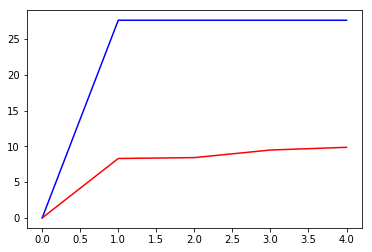

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(d_error_plt, 'b')
plt.plot(g_error_plt, 'r')
filename = "results/" + file_name[:-4] + "/" + "error_growth.txt"
file = open(filename, "w")
file.write("Discriminator error: " + str(d_error_plt) + "\n")
file.write("\n\n\n")
file.write("Generator error: " + str(g_error_plt) + "\n")
file.close()

plt.savefig('images/'+ file_name[:-4] + "/"+ 'error.png')
plt.show()
plt.clf()

In [43]:
points_collection = []
for batch in generated_points:
    if batch[0].size() != []:
        for point in batch:
            point = point.cpu().detach().numpy()
            points_collection.append(point)
df = pd.DataFrame(points_collection, columns=database.get_columns()).round(2)
df.to_csv( "fake_data/" + file_name[:-4] + "_" + str(epoch) + ".csv")

In [44]:
torch.save(discriminator.state_dict(), "models/" + file_name[:-4] + "_" + str(epoch) + "_discriminator.pt")
torch.save(generator.state_dict(), "models/" + file_name[:-4] + "_" + str(epoch) + "generator.pt")